<a href="https://colab.research.google.com/github/codiak/DTSA-5511/blob/main/DTSA_5511_Bank_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification with a Bank Churn Dataset
### Kaggle project as part of CU Boulder DTSA-5511

"Deep Learning" class participation in the Kaggle competition:
[Binary Classification with a Bank Churn Dataset](https://www.kaggle.com/competitions/playground-series-s4e1)

Based on the provided, synthetic data, the goal is to predict which customers will exit the bank.

Completed by Cody P (@codiak).

Github repo: https://github.com/codiak/DTSA-5511

In [1]:
# Import necessary libraries
!pip install kaggle
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


### Data Fetching

Using the Kaggle API to import the dataset.

In [3]:
!mkdir -p ~/.kaggle
!cp /kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c playground-series-s4e1

100% 6.81M/6.81M [00:01<00:00, 8.42MB/s]
100% 6.81M/6.81M [00:01<00:00, 5.27MB/s]


In [4]:
!unzip playground-series-s4e1.zip

Archive:  playground-series-s4e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_df = pd.read_csv('sample_submission.csv')

## Exploratory Data Analysis

In [6]:
train_df.sample(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
50720,50720,15799468,Coles,651,France,Female,33.0,1,0.00,2,1.0,1.0,124045.65,0
34541,34541,15614137,MacDonald,591,France,Female,40.0,7,0.00,2,0.0,0.0,103898.59,0
60246,60246,15773276,Townsend,771,France,Female,35.0,6,114552.60,2,1.0,0.0,73856.28,1
6462,6462,15771742,White,542,France,Male,36.0,8,0.00,2,1.0,1.0,178055.87,0
158959,158959,15780386,Chu,631,France,Male,51.0,1,103895.52,1,0.0,0.0,134876.07,1


In [7]:
test_df.sample(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
70987,236021,15649160,Ni,439,France,Female,41.0,1,70784.27,1,1.0,1.0,30579.82
38045,203079,15703541,Folliero,674,Spain,Female,35.0,2,0.00,2,1.0,1.0,59816.41
70802,235836,15730076,Edwards,833,France,Male,45.0,10,0.00,2,1.0,0.0,67740.08
4592,169626,15567980,Chikwado,774,Germany,Female,56.0,3,105264.88,1,1.0,1.0,86787.41
75524,240558,15573876,Chia,748,France,Male,72.0,8,0.00,2,0.0,1.0,71139.80


The Kaggle competition expects a submission using the test dataset which does not include labels.

Let's take a look at the distribution of labels in train_df.

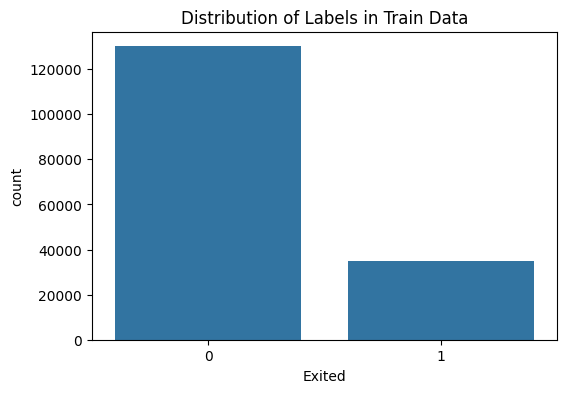

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=train_df)
plt.title('Distribution of Labels in Train Data')
plt.show()

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


The dataset is heavily weighted towards negative samples, which will be worth keeping in mind during training. Otherwise, each of the 11 features do not contain null values.

Lastly, I'm going to verify the distribution of values in various features and compare their saliency.

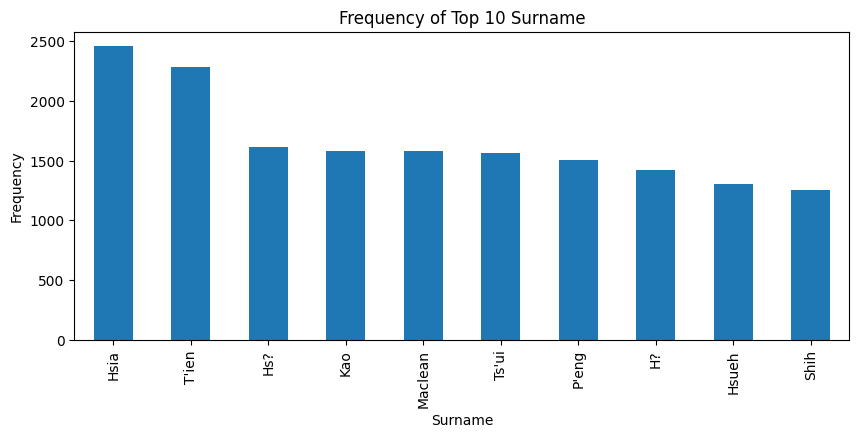

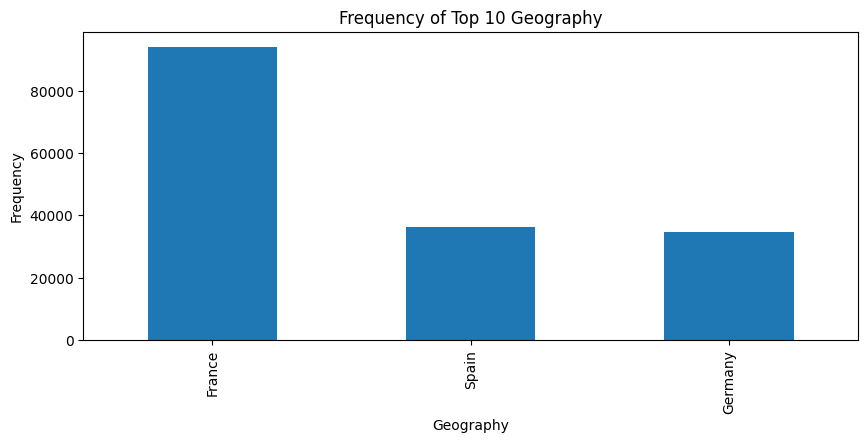

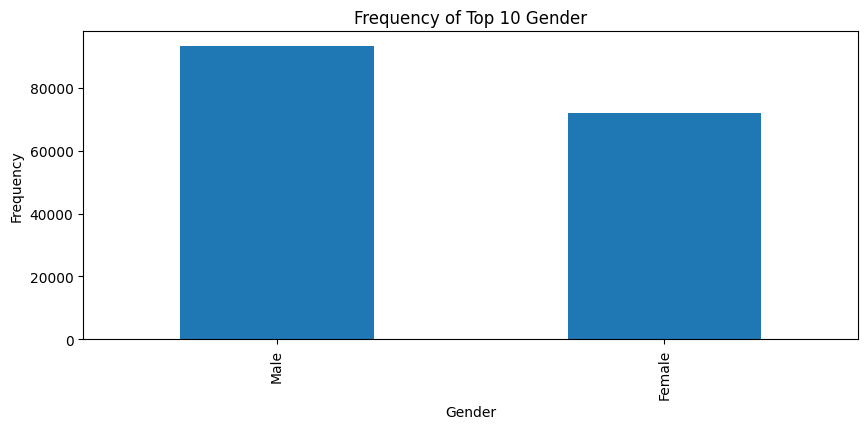

In [11]:
categorical_columns = ['Surname', 'Geography', 'Gender']

for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    train_df[col].value_counts().head(10).plot.bar()  # limiting to top 10 for clarity
    plt.title(f'Frequency of Top 10 {col}')
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.show()

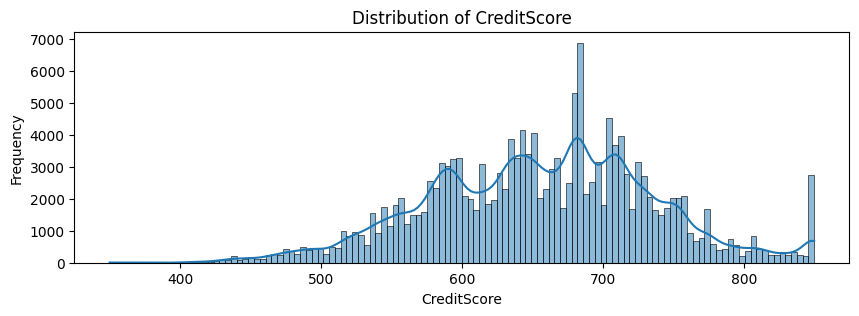

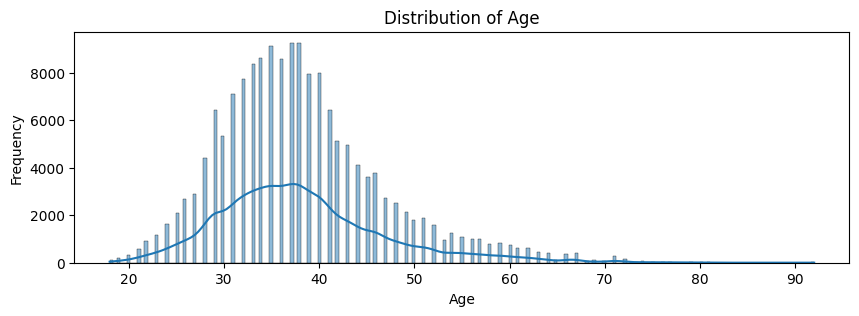

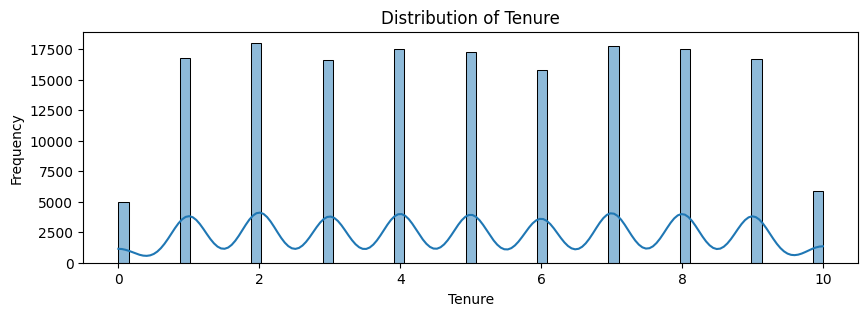

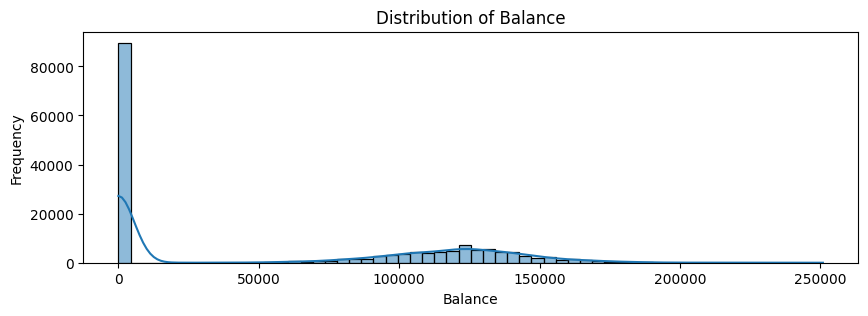

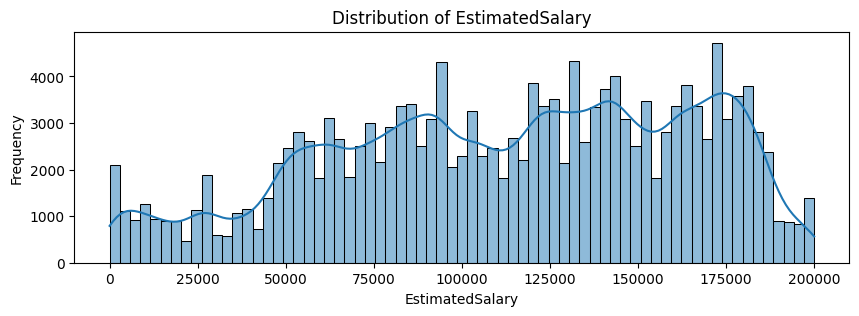

In [13]:
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

for col in numerical_columns:
    plt.figure(figsize=(10, 3))
    sns.histplot(train_df[col], kde=True)  # Histogram with density plot
    plt.title(f'Distribution of {col}')
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.show()

### Data Cleaning

tbd

In [1]:
# tbd

Review transformed/cleaned text values.

In [2]:
# Review cleaning
# train_df.sample(10).loc[:, ['text', 'clean_tokens']]

## Data Preparation for Training

tbd

In [ ]:
# tbd

## Model Training

tbd

In [3]:
# Defining the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

...

Ellipsis

First training

In [4]:
# tbd

In [5]:
# graph train and validation loss
def graph_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

## Conclusion & Analysis

tbd

### Appendix: Kaggle Competition Submission

In [7]:
# Predict and output for test data
# test_pred = model3.predict(X_test)
# # test_targets = np.argmax(test_pred,axis=1)
# test_targets = (test_pred > 0.5).astype("int32")

In [8]:
# # Reduce columns to just ids
# submission_df = test_df.loc[:, test_df.columns.intersection(['id'])]
# submission_df['target'] = test_targets
# submission_df.to_csv('submission.csv', index=False)

In [6]:
# Kaggle submission
# !kaggle competitions submit -c nlp-getting-started -f submission.csv -m "DTSA-5511, v1 (0.5 threshold)"

#### Resources and References

...
